# Some Requirements

IR data must be of the limiting reagent

The limitng reagent must be [A] - will likely be able to change this if requried

The first experiment (R1) must be the standard conditions to which other experiments are compared for RPKA

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import leastsq
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
#import re

# Load IR Data from txt File

In [2]:
globbed_files = glob.glob("*.txt")

frame=[]
for txt in globbed_files:
    
    tmp = pd.read_csv(txt, sep="\t")

    # Add filename as column (make sure that filename.txt is the experiment number)
    exp_no=os.path.splitext(txt)[0]
    tmp['Exp No']=exp_no

    # Change hh:mm:ss format into mins
    #tmp['Relative Time'] = tmp['Relative Time'].str.split(':').apply(lambda x :int(x[0]) * 60 + int(x[1]))
    
    # Change hh:mm:ss format into seconds
    tmp['Relative Time'] = tmp['Relative Time'].str.split(':').apply(lambda x :int(x[0]) * 3600 + int(x[1]) * 60 + int(x[2])) # Why does this work?
    
    # Then back into more useful minutes
    tmp['Relative Time'] = tmp['Relative Time'].astype(int)/60
    
    frame.append(tmp)
    
ir_data = pd.concat(frame, ignore_index=True)
    
#ir_data

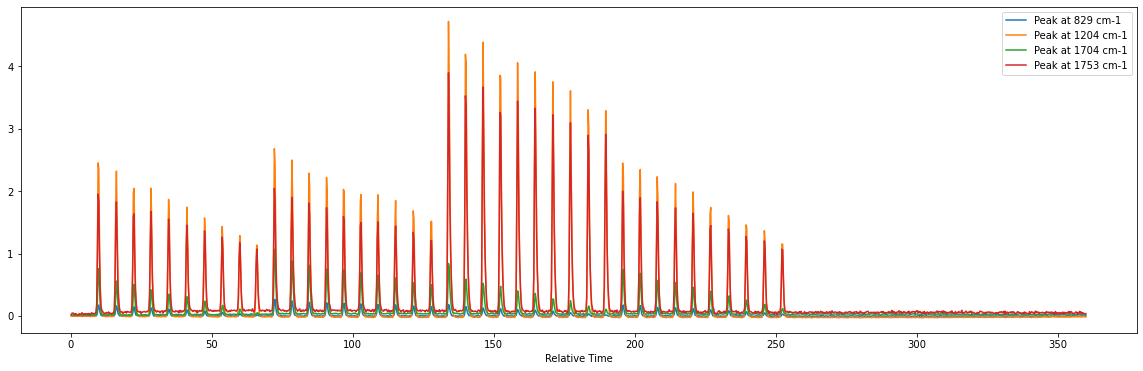

In [3]:
# Visualise the data
fig = ir_data.plot(x='Relative Time',figsize=(20,6))

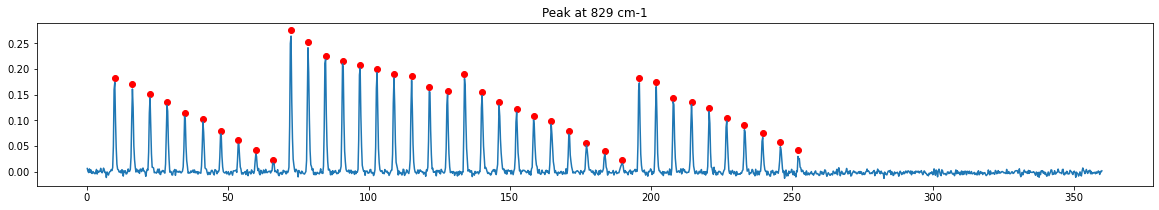

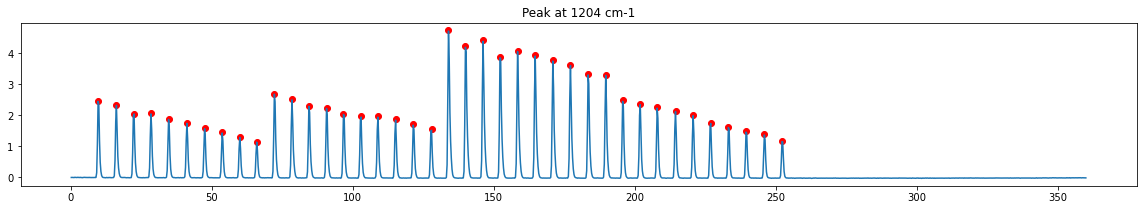

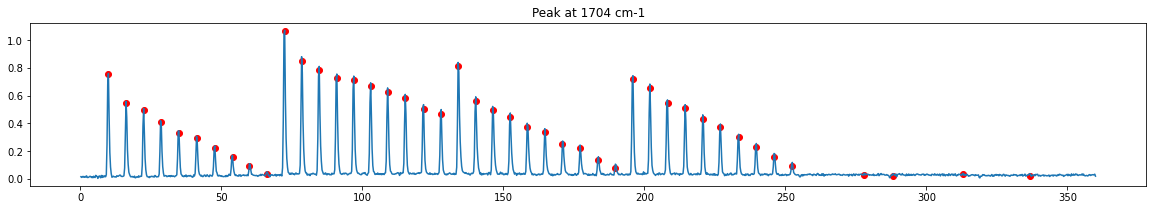

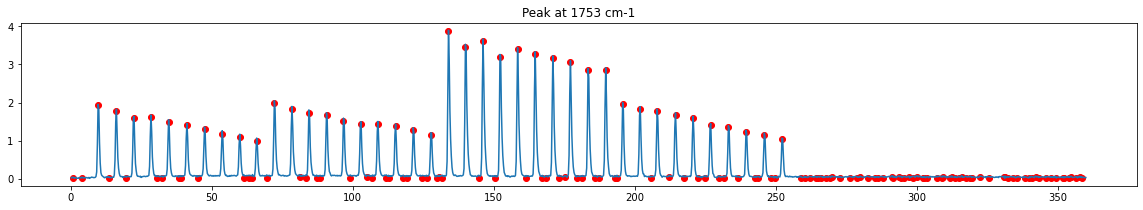

In [19]:
# Finds only the columns containing the string 'Peak'
peak_list = [x for x in list(ir_data) if 'Peak' in x]

# Define peak threshold (check figure above if necessary)
peak_threshold = 0.02

# For loop through each defined peak
processed_ir_data = []
list_of_dfs = []

for var in peak_list:
    # Find single peak
    x = ir_data[var]
    
    # Find peak height and position
    peaks = find_peaks(x, prominence = peak_threshold)
    peak_height = peaks[1]
    peak_pos = ir_data['Relative Time'][peaks[0]]
        
    # Add to dataframe
    tmp = pd.DataFrame(peak_pos).reset_index(drop=True)
    tmp2 = pd.DataFrame(peak_height).rename(columns = {'prominences':var}) # CHANGE THIS IF CHANGING METHOD
    tmp = pd.concat([tmp,tmp2],axis=1).rename(columns={'Relative Time':'Relative Time ' + var})
    
    list_of_dfs.append(tmp)
    
processed_ir_data = pd.concat(list_of_dfs,axis=1)

# Plot all picked peaks
for var in peak_list:
    fig = plt.figure(figsize=(20,3))
    ax = fig.subplots()
    ax.title.set_text(var)
    ax.plot(ir_data['Relative Time'],ir_data[var])
    ax.scatter(processed_ir_data['Relative Time ' + var],processed_ir_data[var], color='r')
    
#processed_ir_data

In [20]:
# Remove IR Peaks if necessary
peak_to_drop = 'Peak at 829 cm-1'
processed_ir_data.drop([col for col in processed_ir_data.columns if peak_to_drop in col], axis=1, inplace=True)

peak_to_drop = 'Peak at 1204 cm-1'
processed_ir_data.drop([col for col in processed_ir_data.columns if peak_to_drop in col], axis=1, inplace=True)

peak_to_drop = 'Peak at 1753 cm-1'
processed_ir_data.drop([col for col in processed_ir_data.columns if peak_to_drop in col], axis=1, inplace=True)

# Tidy data
processed_ir_data.dropna(inplace=True)
processed_ir_data.drop([col for col in processed_ir_data.columns if 'bases' in col], axis=1, inplace=True)

# Replace peak wavelength with reagent name - REMOVE THIS OR MOVE LATER?
#processed_ir_data.columns = processed_ir_data.columns.str.replace('Peak at 1704 cm-1','[A]')

#processed_ir_data

# Load Conditions from Excel File

In [21]:
conditions = pd.read_excel("Conditions.xlsx")  
conditions.loc[conditions.index.repeat(2)]
#conditions

# Expand SPKA conditions for each reaction
experiments = conditions['Experiment'].unique()

data=[]
for var in experiments:
       
    # For single reaction
    tmp = conditions.loc[conditions['Experiment'] == var]
    
    # Find interval size
    interval_size = tmp['Interval Size'].iloc[0]
    
    # Create and append df for each SPKA datapoint
    spka_points = pd.DataFrame(range(0,tmp['SPKA'].iloc[0] - 1), columns=['SPKA']) * interval_size # Must be one less than in excel sheet
    tmp = tmp.drop(['SPKA'],axis=1) # drop manually filled column
    tmp = tmp.append(spka_points, ignore_index=True).ffill()
    
    # Take first row as t0 conditions and duplicate
    t0_cond = pd.DataFrame(tmp.iloc[0,:]).T
    pd.concat([t0_cond,tmp]).reset_index()
    
    data.append(tmp)

processed_conditions=pd.concat(data).reset_index(drop=True).fillna(value='0')

#processed_conditions

# Check that you have the same number of peaks as experimental conditions
if len(processed_ir_data) != len(processed_conditions):
    print('You have a problem: IR datapoints = ',len(processed_ir_data),', Number of conditions = ',len(processed_conditions))
else:
    print('Inputs seem good: IR Datapoints = ',len(processed_ir_data),', Number of conditions = ',len(processed_conditions))

#processed_ir_data
#processed_conditions

Inputs seem good: IR Datapoints =  40 , Number of conditions =  40


In [22]:
# Merge IR and Conditions dataframes
experimental_data = pd.concat([processed_conditions,processed_ir_data],axis=1)
#experimental_data

# Process SPKA Data

In [23]:
# Find unique reaction numbers
reaction_list = experimental_data['Experiment'].unique()

# Find peaks to process
peaks_to_process = [x for x in experimental_data.columns if 'Relative Time' not in x]
peaks_to_process = [x for x in peaks_to_process if 'Peak' in x]

# Define starting material that is monitored
sm_monitored = '[A]0'

#reaction_list
#peaks_to_process

In [24]:
# Calculate SPKA Data - NEEDS TO BE UPDATED TO REMOVE THE FOR LOOP HANDLING MULTIPLE IR PEAKS

data = []
spka_data = []

for reaction in reaction_list:
    
    # Just single reaction
    tmp = experimental_data.loc[experimental_data['Experiment'] == reaction]
    
    # No longer need the 'Relative Time for XX' columns
    tmp = tmp.drop([x for x in tmp.columns if 'Relative Time' in x], axis=1)
            
    # Creat SPKA data for each IR peak monitored
    for ir_peak in peaks_to_process:
        
        # Normalise the IR concentration against the t0 value, set to ideal concentration
        norm_ir_conc = tmp[ir_peak] / tmp[ir_peak].iloc[0] * tmp[sm_monitored].iloc[0]
        
        # Drop the first row as this is t0 data and should not be part of the SPKA profile
        tmp.drop(index=tmp.index[0], axis=0, inplace = True)
        
        # Calculate the SPKA Conversion (a little different to the way currently entered in conditions)
        # Change this to move from starting materials to product
        spka_conv = 1 - (tmp['SPKA'])/100 

        # Calculate the ideal starting concentration for each datapoint
        # Change this if have the actual t0s for each datapoint
        spka_ideal_conc = spka_conv * tmp[sm_monitored]

        # Add these to tmp dataframe
        tmp['SPKA Conversion'] = spka_conv
        tmp['SPKA Ideal t0 Concentration'] = spka_ideal_conc

        # Find the residence time
        residence_time = tmp['tR (min)'].iloc[0]
                
        # Calculate the SPKA rate data
        spka_rate = (spka_ideal_conc - norm_ir_conc) / residence_time
        
        # Calculate the SPKA concentration data
        spka_conc = (spka_ideal_conc - norm_ir_conc) / 2 + norm_ir_conc

        # Add the data to the dataframe
        tmp['Normalised ' + ir_peak] = norm_ir_conc
        tmp['Rate'] = spka_rate
        tmp['[A]'] = spka_conc
               
    data.append(tmp)
    
spka_data = pd.concat(data).reset_index(drop=True)

#spka_data

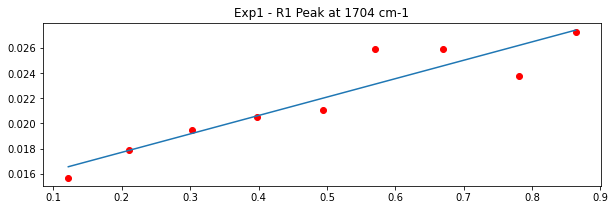

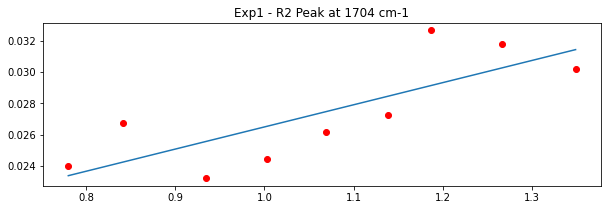

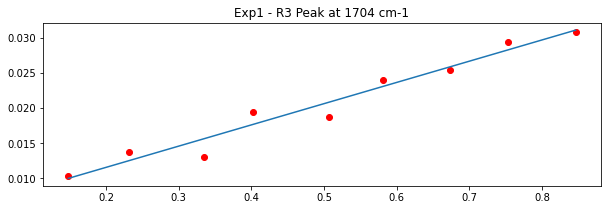

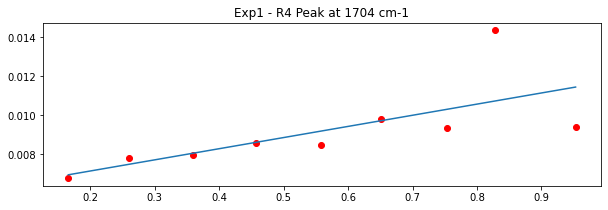

In [25]:
# Plot all picked peaks - select all and ctrl-/ to un/comment
for reaction in reaction_list:
    tmp = spka_data.loc[spka_data['Experiment'] == reaction]

    for var in peaks_to_process:
        fig = plt.figure(figsize=(10,3))
        ax = fig.subplots()
        ax.title.set_text(reaction + ' ' + var)
        ax.scatter(tmp['[A]'],tmp['Rate'], color='r')
        
        #  Find line of best fit => np.polyfit(x, y, 1)
        a, b = np.polyfit(tmp['[A]'].astype(float), tmp['Rate'].astype(float), 1)
        plt.plot(tmp['[A]'], a * tmp['[A]'] + b)

# RPKA - Different Excess

In [26]:
# Some definitions

# For RPKA - first experiment
def func_exp1(x):
    return rate_exp_a/(yconc_exp_a**x) - x_exp_a

# For RPKA - second experiment
def func_exp4(x):
    return rate_exp_b/(yconc_exp_b**x) - x_exp_b

# Residuals for RPKA
def residuals(x):
    return (rate_exp_a/(yconc_exp_a**x) - rate_exp_b/(yconc_exp_b**x))

def sum_residuals(x):
    return sum(residuals(x)**2)

In [27]:
# Calculate Excess
spka_data['[Excess]'] = spka_data['[B]0'] - spka_data['[A]0']
spka_data['[B]'] = spka_data['[A]'] + spka_data['[Excess]']
spka_data['[C]'] = spka_data['[C]0']

# Determine which experiments look at which reagent
rpka_experiments = {}

for var in range(1, len(experiments)):
    
    # Select the first experiment and the nth experiment
    tmp = spka_data.loc[spka_data['Experiment'].isin([experiments[0],experiments[var]])]

    # Drop all columns which have only a single unique value, the second column is now the reagent we want - THIS MIGHT CAUSE PROBLEMS
    nunique = tmp.nunique()
    cols_to_drop = nunique[nunique == 1].index
    tmp = tmp.drop(cols_to_drop, axis=1)
    
    # The second columnd will contain the compound which is changing
    rpka_reagent = tmp.columns[1]
    rpka_reagent = rpka_reagent[rpka_reagent.find("[")+1:rpka_reagent.find("]")]
    
    rpka_experiments[experiments[var]] = rpka_reagent

#rpka_experiments

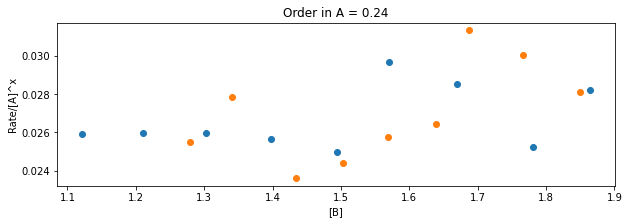

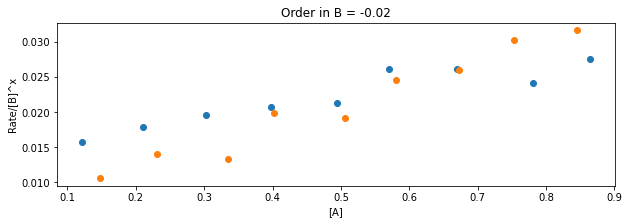

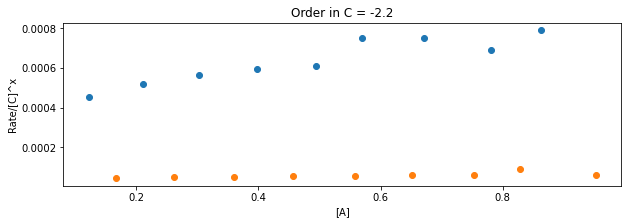

In [106]:
# RPKA loop

for var in range(1, len(experiments)):
    
    # exp_a will always be R1
    exp_a = experiments[0]
    exp_b = experiments[var]
    
    # Define substrate to process
    rpka_reagent = rpka_experiments[experiments[var]]
    
    # Check whether the reagent is the limiting reagnet (should be A, the first entry) or not as axes will be different
    if rpka_reagent == rpka_experiments[experiments[1]]:

        reagent_on_y_axis = '[' + rpka_experiments[experiments[1]] + ']'
        reagent_on_x_axis = '[' + rpka_experiments[experiments[var+1]] + ']'

    else:

        reagent_on_y_axis = '[' + rpka_experiments[experiments[var]] + ']'
        reagent_on_x_axis = '[' + rpka_experiments[experiments[1]]  + ']'   

    # Define exp_a
    x_exp_a = spka_data[reagent_on_x_axis].loc[spka_data['Experiment'] == exp_a].to_numpy()
    rate_exp_a = spka_data['Rate'].loc[spka_data['Experiment'] == exp_a].to_numpy()
    yconc_exp_a = spka_data[reagent_on_y_axis].loc[spka_data['Experiment'] == exp_a].to_numpy()

    # Define exp_b
    x_exp_b = spka_data[reagent_on_x_axis].loc[spka_data['Experiment'] == exp_b].to_numpy()
    rate_exp_b = spka_data['Rate'].loc[spka_data['Experiment'] == exp_b].to_numpy()
    yconc_exp_b = spka_data[reagent_on_y_axis].loc[spka_data['Experiment'] == exp_b].to_numpy()

    # Calculate order
    reagent_order = np.round(minimize(sum_residuals, 1).x,2)
    spka_data['Order in ' + rpka_reagent] = pd.Series(reagent_order)
    
    # Plot
    fig = plt.figure(figsize=(10,3))
    plt.title('Order in ' + rpka_reagent + ' = ' + spka_data['Order in ' + rpka_reagent].iloc[0].astype(str))
    plt.xlabel(reagent_on_x_axis)
    plt.ylabel('Rate/' + reagent_on_y_axis + '^x')
    plt.scatter(x_exp_a, rate_exp_a/yconc_exp_a**spka_data['Order in ' + rpka_reagent].iloc[0])
    plt.scatter(x_exp_b, rate_exp_b/yconc_exp_b**spka_data['Order in ' + rpka_reagent].iloc[0])   

#spka_data.fillna(method="ffill")

In [ ]:
for var in peaks_to_process:
        fig = plt.figure(figsize=(10,3))
        ax = fig.subplots()
        ax.title.set_text(reaction + ' ' + var)
        ax.scatter(tmp['[A]'],tmp['Rate'], color='r')
        
        #  Find line of best fit => np.polyfit(x, y, 1)
        a, b = np.polyfit(tmp['[A]'].astype(float), tmp['Rate'].astype(float), 1)
        plt.plot(tmp['[A]'], a * tmp['[A]'] + b)

# Write to Excel

In [91]:
# Set up excelwriter
writer = pd.ExcelWriter(exp_no +' Processed.xlsx', engine='xlsxwriter')
workbook=writer.book

# Output data
spka_data.to_excel(writer, sheet_name='SPKA Data', startrow=0 , startcol=0, index=False)
ir_data.to_excel(writer, sheet_name='IR Data', startrow=0 , startcol=0, index=False)
processed_ir_data.to_excel(writer, sheet_name='Processed IR', startrow=0 , startcol=0, index=False)
experimental_data.to_excel(writer, sheet_name='Experimental Data', startrow=0 , startcol=0, index=False)
conditions.to_excel(writer, sheet_name='Conditions', startrow=0 , startcol=0, index=False)

# Save
writer.save()

# This won't work if the excel file is open